### Домашнее задание 12
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home
5. попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

In [2]:
import torch as tr 
from gensim.models import Word2Vec
import pandas as pd
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)
text_y = np.array([[''.join(re.findall(f'[a-z ]', t)), y] for t, y  in zip(data.normalized_text.to_list(), data.raw_character_text.to_list()) if type(t) is str])
text = text_y[:,0]
sents = [sent.split(' ') for sent in text]
model = Word2Vec(sents, min_count=1)

/var/folders/br/4lxt1sqs0sjbwhyw5my_00jw0000gn/T/ipykernel_57495/2916017180.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)
Skipping line 8084: expected 13 fields, saw 20
Skipping line 52607: expected 13 fields, saw 21
Skipping line 59910: expected 13 fields, saw 21

Skipping line 71801: expected 13 fields, saw 20
Skipping line 73539: expected 13 fields, saw 21
Skipping line 77230: expected 13 fields, saw 21
Skipping line 78953: expected 13 fields, saw 21
Skipping line 81138: expected 13 fields, saw 20
Skipping line 86746: expected 13 fields, saw 22
Skipping line 101154: expected 13 fields, saw 21
Skipping line 115438: expected 13 fields, saw 20
Skipping line 117573: expected 13 fields, saw 22
Skipping line 130610: expected 13 fields, saw 22

Skipping line 152970: expected 13 fields, saw 22
Skipping line 153017: expect

In [5]:
words = list(model.wv.key_to_index.keys())
vec = model.wv[model.wv.key_to_index.keys()]
words1000 = words[:1000]
vec1000 = vec[:1000]
pca = PCA(n_components = 2)
res = pca.fit_transform(vec1000)

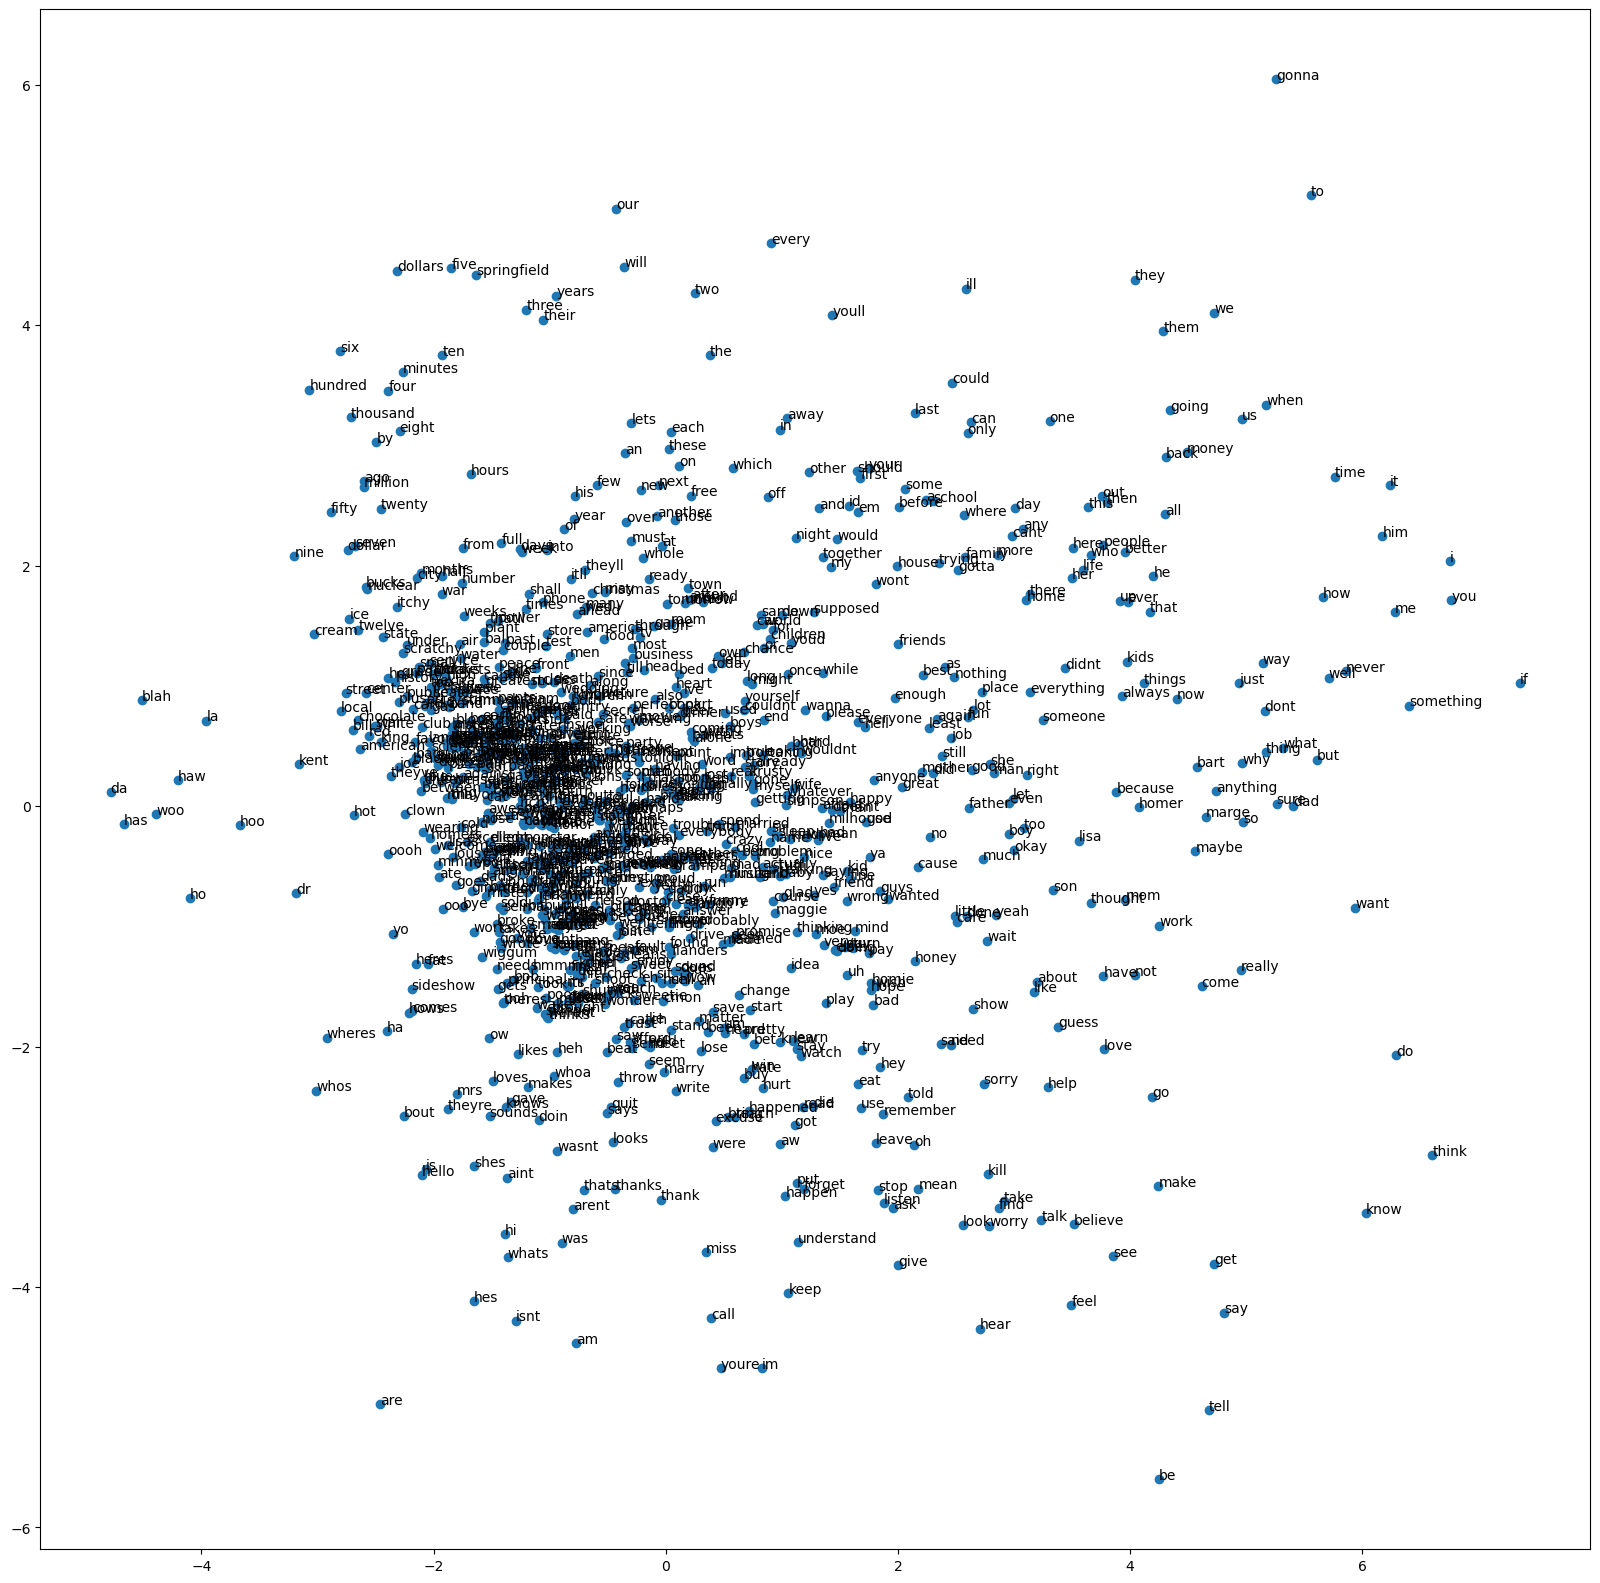

In [6]:
plt.scatter(res[:,0], res[:,1])
for i, word in enumerate(words1000):
	  plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.gcf().set_size_inches(20, 20)

In [7]:
print(f"homer - marge + bart:\n {model.wv.most_similar(positive=['homer', 'bart'], negative=['marge'])}\n")
print(f"bart - lisa + school:\n {model.wv.most_similar(positive=['school', 'bart'], negative=['lisa'])}\n")
print(f"marge - homer + home:\n {model.wv.most_similar(positive=['marge', 'home'], negative=['homer'])}\n")

homer - marge + bart:
 [('lisa', 0.8155198693275452), ('grampa', 0.6835243105888367), ('milhouse', 0.6623097062110901), ('son', 0.6425858736038208), ('dad', 0.6389347314834595), ('abe', 0.6119611263275146), ('genes', 0.6053187847137451), ('father', 0.6017794013023376), ('maggie', 0.6016315221786499), ('bbart', 0.6015121340751648)]

bart - lisa + school:
 [('house', 0.7756341099739075), ('game', 0.7555239796638489), ('church', 0.7474378347396851), ('town', 0.7432080507278442), ('end', 0.7315370440483093), ('once', 0.7234479784965515), ('store', 0.7164599299430847), ('night', 0.7103670239448547), ('world', 0.7080383896827698), ('work', 0.7008735537528992)]

marge - homer + home:
 [('back', 0.801531970500946), ('sleep', 0.7273317575454712), ('bed', 0.7183546423912048), ('together', 0.6670821905136108), ('dinner', 0.6670063734054565), ('here', 0.6587722897529602), ('school', 0.6514928340911865), ('tomorrow', 0.6415444016456604), ('car', 0.6259896755218506), ('now', 0.6225541234016418)]



In [8]:
text_bart = [''.join(re.findall(f'[a-z ]', t)) for t in data[data.raw_character_text == 'Bart Simpson'].normalized_text.to_list() if type(t) is str]
text_lisa = [''.join(re.findall(f'[a-z ]', t)) for t in data[data.raw_character_text == 'Lisa Simpson'].normalized_text.to_list() if type(t) is str]
sents_bart = [sent.split(' ') for sent in text_bart]
sents_lisa = [sent.split(' ') for sent in text_lisa]

In [9]:
word_bart = set()
for s in sents_bart:
    word_bart |= set(s)

word_lisa = set()
for s in sents_lisa:
    word_lisa |= set(s)

In [10]:
word_bart_uniq = word_bart - word_lisa
word_lisa_uniq = word_lisa - word_bart
word_lisa_bart = word_lisa & word_bart

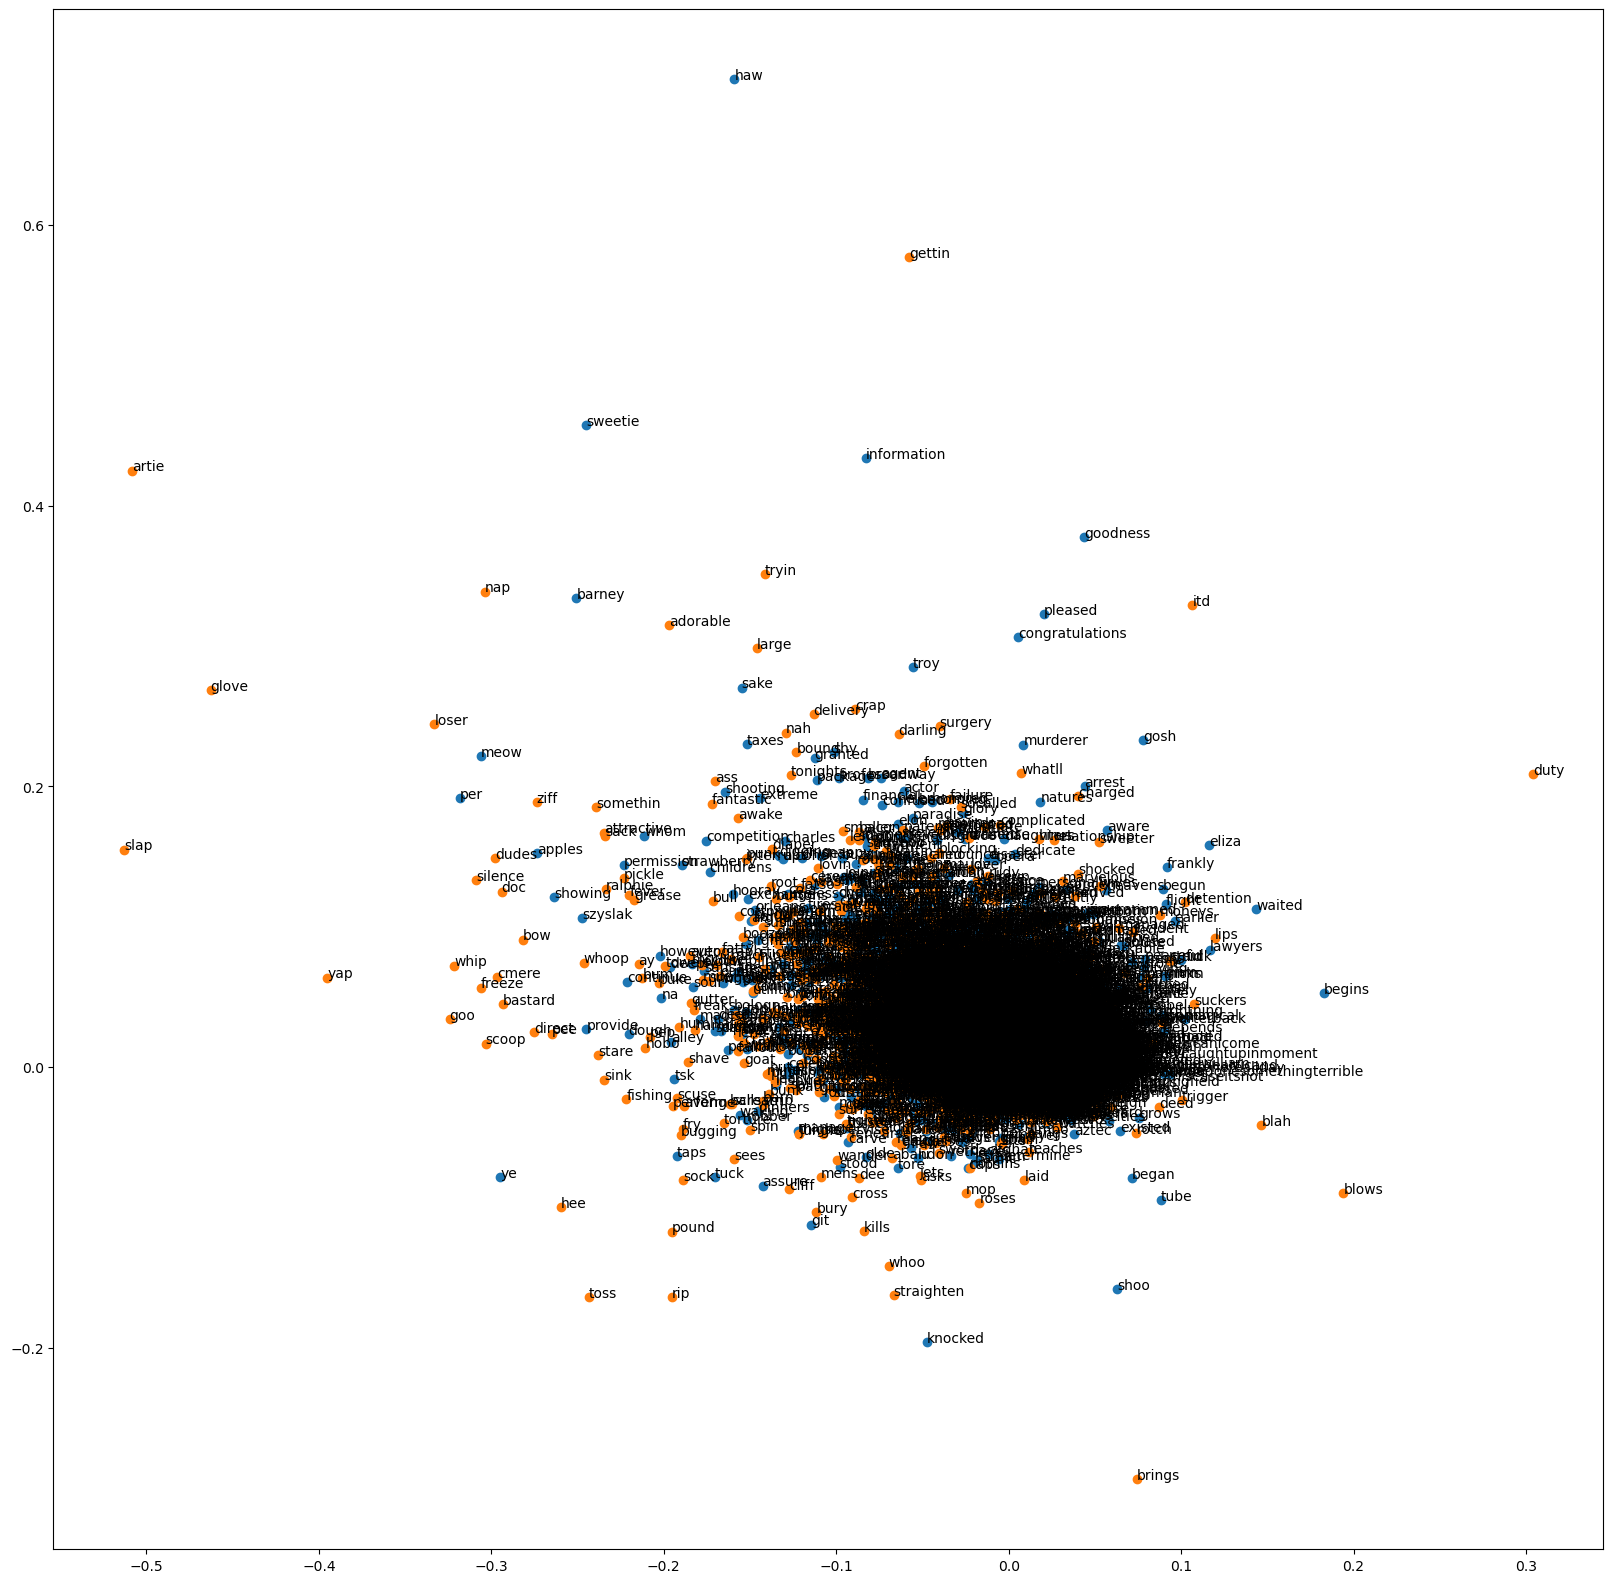

In [11]:
for words in [word_lisa_uniq, word_bart_uniq]:
    res = model.wv[words]
    plt.scatter(res[:,0], res[:,1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(res[i, 0], res[i, 1]) )
plt.gcf().set_size_inches(20, 20)

In [12]:
batch_size = 5000
data_size = len(sents)
sent_size = 150
vec_size = model.wv.get_vector('do').shape[0]
y = [1*(o == "Lisa Simpson") + 2*(o == 'Bart Simpson')  for o in text_y[:,1]]
n_classes = len(set(y))

train = []
for i0, sent in enumerate(sents[:100000]):
    X = tr.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = tr.tensor(model.wv[word])
        X[i1] = r
    train.append((X.T, y[i0]))

test = []
for i0, sent in enumerate(sents[100000:]):
    X = tr.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = tr.tensor(model.wv[word])
        X[i1] = r
    test.append((X.T, y[i0 + 100000]))

In [13]:
data_train = tr.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)
data_test = tr.utils.data.DataLoader(test, batch_size = batch_size, shuffle=True)

In [14]:
dev = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
print(f"work on {(tr.cuda.get_device_name() if dev.type == 'cuda' else 'cpu')}")

work on cpu


In [15]:
class Net1(tr.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tr.nn.Conv1d(100, 100, 5)
        self.norm1 = tr.nn.BatchNorm1d(100)
        self.conv2 = tr.nn.Conv1d(100, 100, 3)
        self.norm2 = tr.nn.BatchNorm1d(100)
        self.relu = tr.nn.ReLU6()
        self.flat = tr.nn.Flatten()
        self.fc1 = tr.nn.Linear(14400, n_classes)
    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [16]:
model1 = Net1().to(dev)

In [ ]:
optim = tr.optim.Adam(model1.parameters())
crit = tr.nn.CrossEntropyLoss()
n_iters = 10

for iter in range(n_iters):
    model1.train()
    for X, y in data_train:
        X, y = X.to(dev), y.to(dev)
        optim.zero_grad()
        pred = model1(X)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
    train_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]

    model1.eval()
    for X, y in data_test:
        X, y = X.to(dev), y.to(dev)
        pred = model1(X)
        test_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}')
        break
    if test_score > 0.98:
        break

iter 0, loss = 0.6017940640449524, train score = 0.819, test score = 0.8066
